## Impute Missing Data

The loading data step is the same as in explanatory analysis.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import miceforest as mf

# Read data
cis2018 = pd.read_csv(f"/Volumes/K的1TB/ECO480/Term_Paper/Data/2018sub-data.txt")

# List of variables to keep
variables_to_keep = ["efmjie", "fschhldm", "efagofmp", "efagyfmp", "efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efmjsi", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp", "prov", "dwltyp", "dwtenr", "marstp","eftyp","hlev2g","sex","immst","uszgap"]

# Keep observations where efmjieh equals 1
new_dataset_efmjieh1 = cis2018[variables_to_keep]
new_dataset_efmjieh1 = new_dataset_efmjieh1[new_dataset_efmjieh1['efmjie'] == 1]

# Remove column 'efmjie'
new_dataset_efmjieh1 = new_dataset_efmjieh1.drop(columns=['efmjie'])

# Set certain values to NaN
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['dwltyp'] >= 6, 'dwltyp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['marstp'] >= 6, 'marstp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['eftyp'] >= 96, 'eftyp'] = np.nan
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['hlev2g'] >= 6, 'hlev2g'] = np.nan
df_imputed = new_dataset_efmjieh1.copy()

In our dataset, four variables were identified as having missing values, characterized as either categorical or ordinal (`dwltyp`, `marstp`, `eftyp`, and `hlev2g`). The distribution of these variables across different levels of food insecurity was uneven. Here we provide an example of the variable ‘Type of Dwelling’. Furthermore, given the presence of both categorical and ordinal variables (the latter being treatable as numerical variables in discrete quantities), we employed the Memory Efficient Multiple Imputation by Chained Equations (MICE) algorithm to impute the missing values. 

### Variables with Missing Values

| Variable | Description | Variable Type | Count | Proportion |
| --- | --- | --- | --- | --- |
| dwltyp | Type of dwelling | Categorical | 2277 | 0.053656 |
| marstp | Marital status | Categorical | 1859 | 0.043806 |
| eftyp | Economic family type | Categorical | 859 | 0.020242 |
| hlev2g | Highest level of education of person | Ordinal | 1824 | 0.042981 |


In [2]:
new_dataset_efmjieh1['dwltyp'].value_counts(normalize=True, dropna=False)

1.0    0.618917
3.0    0.197681
2.0    0.113957
NaN    0.053656
4.0    0.015788
Name: dwltyp, dtype: float64

<Figure size 1000x600 with 0 Axes>

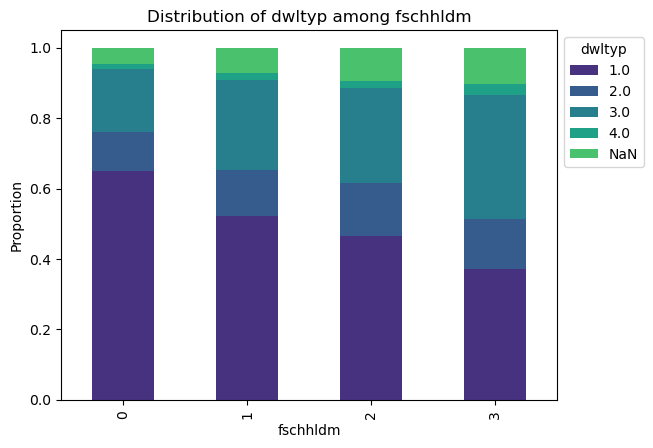

In [3]:
# Replace NaN values in 'dwltyp' column with a string label to include them in the plot
new_dataset_efmjieh1['dwltyp'] = new_dataset_efmjieh1['dwltyp'].fillna('NaN')

# Group the data by 'fschhldm' and 'dwltyp' and count the occurrences
grouped_data = new_dataset_efmjieh1.groupby(['fschhldm', 'dwltyp']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plot the stacked bar chart
plt.figure(figsize=(10, 6))
sns.set_palette("viridis")
grouped_data.plot(kind='bar', stacked=True)
plt.xlabel('fschhldm')
plt.ylabel('Proportion')
plt.title('Distribution of dwltyp among fschhldm')
plt.legend(title='dwltyp', bbox_to_anchor=(1, 1))
plt.show()

In [4]:
# Replace NaN values in 'dwltyp' column with a string label to include them in the calculation
new_dataset_efmjieh1['dwltyp'] = new_dataset_efmjieh1['dwltyp'].fillna('NaN')

# Calculate the proportion of each dwltyp in each fschhldm
proportions = new_dataset_efmjieh1.groupby(['fschhldm', 'dwltyp']).size() / new_dataset_efmjieh1.groupby('fschhldm')['dwltyp'].size()

# Reset the index and pivot the data to create a table
proportions = proportions.reset_index().pivot(index='fschhldm', columns='dwltyp', values=0).fillna(0)

# Display the proportions
print(proportions)


dwltyp         1.0       2.0       3.0       4.0       NaN
fschhldm                                                  
0         0.651466  0.108267  0.179550  0.014437  0.046279
1         0.521739  0.130935  0.254873  0.019990  0.072464
2         0.465222  0.151084  0.270463  0.018764  0.094468
3         0.371604  0.140953  0.352640  0.031266  0.103537


### Distribution of dwelling among each level of food insecurity

| fschhldm  | dwltyp 1.0 | dwltyp 2.0 | dwltyp 3.0 | dwltyp 4.0 | dwltyp NaN |
| --------- | ---------- | ---------- | ---------- | ---------- | ---------- |
| 0         | 0.651466   | 0.108267   | 0.179550   | 0.014437   | 0.046279   |
| 1         | 0.521739   | 0.130935   | 0.254873   | 0.019990   | 0.072464   |
| 2         | 0.465222   | 0.151084   | 0.270463   | 0.018764   | 0.094468   |
| 3         | 0.371604   | 0.140953   | 0.352640   | 0.031266   | 0.103537   |

In [5]:
# Specify the variables to scale
numerical_variables = ["efalimo", "efalip", "efcapgn", "efccar", "efchtxb", 
"efcpqpp", "efearng", "efgi", "efgstxc", "efgtr", "efinva", "efoasgi", "efogovtr", "efothinc", "efpen", "efpenrec", "efphpr", "efpvtxc", "efrppc", "efrspwi", "efsapis", "efsemp", 
"efsize", "efuiben", "efwkrcp"]

# Specify categorical variables
categorical_variables = ["eftyp", "prov", "dwltyp", "dwtenr", "marstp", "efmjsi","sex","immst","uszgap"]
ordinal_variables = ["efagofmp", "efagyfmp", "hlev2g"]
new_dataset_efmjieh1.loc[new_dataset_efmjieh1['fschhldm'] >= 1, 'fschhldm'] = 1

In [6]:
print(new_dataset_efmjieh1['dwltyp'].dtype)

object


In [7]:
# Convert categorical variables to 'category' type
for var in categorical_variables:
    df_imputed[var] = df_imputed[var].astype('category')

# Consider ordinal variables as numerical for the MICE algorithm, hence no need to convert

# Create kernel.
kds = mf.ImputationKernel(
  df_imputed,   # input dataframe
  save_all_iterations=True,
  random_state=42
)

# Run the MICE algorithm for some number of iterations, let's say 3
kds.mice(3)

# Return the completed data
completed_data = kds.complete_data()

# Replace original dataframe with the imputed dataframe
df_imputed = completed_data

In [8]:
missing_values_count = df_imputed.isnull().sum()
print(missing_values_count)

fschhldm    0
efagofmp    0
efagyfmp    0
efalimo     0
efalip      0
efcapgn     0
efccar      0
efchtxb     0
efcpqpp     0
efearng     0
efgi        0
efgstxc     0
efgtr       0
efinva      0
efmjsi      0
efoasgi     0
efogovtr    0
efothinc    0
efpen       0
efpenrec    0
efphpr      0
efpvtxc     0
efrppc      0
efrspwi     0
efsapis     0
efsemp      0
efsize      0
efuiben     0
efwkrcp     0
prov        0
dwltyp      0
dwtenr      0
marstp      0
eftyp       0
hlev2g      0
sex         0
immst       0
uszgap      0
dtype: int64


In [9]:
ordinal_categorical_cols = ['eftyp', 'prov', 'dwltyp', 'dwtenr', 'marstp', 'efmjsi', 'sex', 'immst',
                    'uszgap', 'efagofmp', 'efagyfmp', 'hlev2g']

# Create a Markdown table header
markdown_table = "| Variable | Counts |\n|:---------|-------:|\n"

for col in ordinal_categorical_cols:
    # Get the value counts for the column
    value_counts = df_imputed[col].value_counts(dropna=False)
    
    # Convert value counts to Markdown format
    counts_table = "\n".join([f"{index} | {value}" for index, value in value_counts.items()])
    
    # Append the Markdown table row for the current variable
    markdown_table += f"| {col} | {counts_table} |\n"

# Print the Markdown table
print(markdown_table)

| Variable | Counts |
|:---------|-------:|
| eftyp | 22.0 | 8005
21.0 | 6975
24.0 | 5372
13.0 | 5088
14.0 | 4042
12.0 | 3566
23.0 | 2195
11.0 | 1800
31.0 | 1646
43.0 | 1129
44.0 | 1077
41.0 | 562
42.0 | 513
32.0 | 467 |
| prov | 35 | 11125
24 | 8059
59 | 4874
48 | 4335
46 | 3321
47 | 3083
12 | 2466
13 | 2316
10 | 1651
11 | 1207 |
| dwltyp | 1.0 | 27555
3.0 | 8949
2.0 | 5196
4.0 | 737 |
| dwtenr | 1 | 30129
2 | 12308 |
| marstp | 1.0 | 19180
4.0 | 9622
3.0 | 9159
2.0 | 4476 |
| efmjsi | 2 | 24885
4 | 9850
6 | 4730
3 | 1496
5 | 1158
7 | 318 |
| sex | 1 | 24562
2 | 17875 |
| immst | 2 | 35765
1 | 5961
9 | 711 |
| uszgap | 6 | 12355
9 | 11682
1 | 6299
2 | 3381
5 | 2404
3 | 2399
4 | 2295
7 | 873
8 | 749 |
| efagofmp | 15 | 9297
13 | 4495
12 | 4438
14 | 4195
11 | 3709
10 | 3367
8 | 3313
9 | 3168
7 | 2952
6 | 2247
5 | 1237
4 | 19 |
| efagyfmp | 15 | 6578
1 | 4475
13 | 3809
5 | 3603
12 | 3399
14 | 3366
3 | 2982
6 | 2705
11 | 2435
2 | 2191
7 | 1914
10 | 1614
8 | 1262
9 | 1183
4 | 921 |
| hlev2

| Variable | Index | Label                                                      | Counts |
|:---------|:-----:|:-----------------------------------------------------------|-------:|
| eftyp    | 22  | Non-elderly couple with children                           |   8005 |
| eftyp    | 21  | Non-elderly couple with no children or relatives           |   6975 |
| eftyp    | 24  | Elderly couple with no children or other relatives         |   5372 |
| eftyp    | 13  | Non-elderly male not in an economic family                 |   5088 |
| eftyp    | 14  | Non-elderly female not in an economic family               |   4042 |
| eftyp    | 12  | Elderly female not in an economic family                   |   3566 |
| eftyp    | 23  | Non-elderly couple with other relatives, no children       |   2195 |
| eftyp    | 11  | Elderly male not in an economic family                     |   1800 |
| eftyp    | 31  | Female lone-parent family                                  |   1646 |
| eftyp    | 43  | Other family type - non-elderly male                       |   1129 |
| eftyp    | 44  | Other family type - non-elderly female                     |   1077 |
| eftyp    | 41  | Other family type - elderly male                           |    562 |
| eftyp    | 42  | Other family type - elderly female                         |    513 |
| eftyp    | 32  | Male lone-parent family                                    |    467 |
| prov     | 35    | Newfoundland and Labrador                                 |  11125 |
| prov     | 24    | Quebec                                                    |   8059 |
| prov     | 59    | British Columbia                                          |   4874 |
| prov     | 48    | Alberta                                                   |   4335 |
| prov     | 46    | Manitoba                                                  |   3321 |
| prov     | 47    | Saskatchewan                                              |   3083 |
| prov     | 12    | Nova Scotia                                               |   2466 |
| prov     | 13    | New Brunswick                                             |   2316 |
| prov     | 10    | Newfoundland and Labrador                                 |   1651 |
| prov     | 11    | Prince Edward Island                                      |   1207 |
| dwltyp   | 1   | Single detached house                                     |  27555 |
| dwltyp   | 3   | Apartment                                                 |   8949 |
| dwltyp   | 2   | Double, row or terrace, duplex                            |   5196 |
| dwltyp   | 4   | Other                                                     |    737 |
| dwtenr   | 1     | Owned by a member of the household                        |  30129 |
| dwtenr   | 2     | Not owned by a member of the household                    |  12308 |
| marstp   | 1  | Married                                                   |  19180 |
| marstp   | 4   | Single (never married)                                    |   9622 |
| marstp   | 3  | Separated, divorced or widowed                            |   9159 |
| marstp   | 2  | Common-law                                                |   4476 |
| efmjsi   | 1     | No income                                                 |      0 |
| efmjsi   | 2     | Wages and salaries                                        |  24885 |
| efmjsi   | 4     | Government transfers                                      |   9850 |
| efmjsi   | 6     | Retirement pensions                                       |   4730 |
| efmjsi   | 3     | Self-employment income                                    |   1496 |
| efmjsi   | 5     | Investment income                                         |   1158 |
| efmjsi   | 7     | Other income                                              |    318 |
| sex      | 1     | Male                                                      |  24562 |
| sex      | 2     | Female                                                    |  17875 |
| immst    | 2     | No                                                        |  35765 |
| immst    | 1     | Yes                                                       |   5961 |
| immst    | 9     | Unknown                                                   |    711 |
| uszgap   | 6     | Rural area outside CMAs or CAs                            |  12355 |
| uszgap   | 9     | CMA, population 500,000 and over                          |  11682 |
| uszgap   | 1     | Rural area or CA, population under 100,000                |   6299 |
| uszgap   | 2     | CA, population under 30,000                               |   3381 |
| uszgap   | 5     | CA, population under 100,000                              |   2404 |
| uszgap   | 3     | CA, population 30,000 to 99,999                          |   2399 |
| uszgap   | 4     | CA, pop. under 100,000 or CMA, pop. 100,000 to 499,999    |   2295 |
| uszgap   | 7     | CMA, population 100,000 to 499,999                        |    873 |
| uszgap   | 8     | CA, pop. 30,000 to 99,999 or CMA, pop. 100,000 to 499,999 |    749 |
| efagofmp | 15    | 70 years and over                                         |   9297 |
| efagofmp | 13    | 60 to 64 years                                            |   4495 |
| efagofmp | 12    | 55 to 59 years                                            |   4438 |
| efagofmp | 14    | 65 to 69 years                                            |   4195 |
| efagofmp | 11    | 50 to 54 years                                            |   3709 |
| efagofmp | 10    | 45 to 49 years                                            |   3367 |
| efagofmp | 8     | 35 to 39 years                                            |   3313 |
| efagofmp | 9     | 40 to 44 years                                            |   3168 |
| efagofmp | 7     | 30 to 34 years                                            |   2952 |
| efagofmp | 6     | 25 to 29 years                                            |   2247 |
| efagofmp | 5     | 18 to 24 years                                            |   1237 |
| efagofmp | 4     | Unknown                                                   |     19 |
| efagyfmp | 15    | 70 years and over                                         |   6578 |
| efagyfmp | 1     | 0 to 5 years                                              |   4475 |
| efagyfmp | 13    | 60 to 64 years                                            |   3809 |
| efagyfmp | 5     | 18 to 24 years                                            |   3603 |
| efagyfmp | 12    | 55 to 59 years                                            |   3399 |
| efagyfmp | 14    | 65 to 69 years                                            |   3366 |
| efagyfmp | 3     | 10 to 15 years                                            |   2982 |
| efagyfmp | 6     | 25 to 29 years                                            |   2705 |
| efagyfmp | 11    | 50 to 54 years                                            |   2435 |
| efagyfmp | 2     | 6 to 9 years                                              |   2191 |
| efagyfmp | 7     | 30 to 34 years                                            |   1914 |
| efagyfmp | 10    | 45 to 49 years                                            |   1614 |
| efagyfmp | 8     | 35 to 39 years                                            |   1262 |
| efagyfmp | 9     | 40 to 44 years                                            |   1183 |
| efagyfmp | 4     | 16 to 17 years                                            |    921 |
| hlev2g   | 3   | Non-university postsecondary certificate or diploma       |   14736 |
| hlev2g   | 4   | University degree or certificate                          |   12043 |
| hlev2g   | 2   | Graduated high school or partial postsecondary education |   9889 |
| hlev2g   | 1   | Less than high school graduation                          |   5769 |
